# RNNs model 

In [49]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Load data
url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv'
df = pd.read_csv(url, header=0, index_col=0, parse_dates=True)

# Prepare data
sequence_length = 20 # number of time steps in each input sequence
train_size = int(len(df) * 0.7) # use 70% of data for training
train_data = df.iloc[:train_size]['value'].values
test_data = df.iloc[train_size:]['value'].values
train_sequences = [train_data[i:i+sequence_length] for i in range(len(train_data)-sequence_length)]
test_sequences = [test_data[i:i+sequence_length] for i in range(len(test_data)-sequence_length)]
X_train = np.array(train_sequences[:-1]).reshape(-1, sequence_length, 1)
y_train = np.array(train_sequences[1:]).reshape(-1, sequence_length, 1)
X_test = np.array(test_sequences[:-1]).reshape(-1, sequence_length, 1)
y_test = np.array(test_sequences[1:]).reshape(-1, sequence_length, 1)

# Build RNN model
model = Sequential()
model.add(LSTM(units=64, input_shape=(sequence_length, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mse')

# Train model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Predict anomaly scores for test data
y_pred = model.predict(X_test)

# Find optimal threshold using F1-score
def find_optimal_threshold(y_true, y_pred):
    thresholds = np.linspace(0, 1, 101)
    f1_scores = []
    for threshold in thresholds:
        y_pred_binary = (y_pred > threshold).astype(int)
        f1_score = 2 * (np.sum(y_true * y_pred_binary) / (np.sum(y_true) + np.sum(y_pred_binary)))
        f1_scores.append(f1_score)
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    return optimal_threshold

optimal_threshold = find_optimal_threshold(y_test, y_pred)
# Set threshold value
threshold = 0.5

# Compute predicted values and classify as anomaly or not
y_pred = (model.predict(X_test) > threshold).astype(int)
y_test = (y_test > threshold).astype(int)

# Compute evaluation metrics
tp = np.sum(np.logical_and(y_test == 1, y_pred == 1))
fp = np.sum(np.logical_and(y_test == 0, y_pred == 1))
fn = np.sum(np.logical_and(y_test == 1, y_pred == 0))

if tp + fp > 0:
    precision = tp / (tp + fp)
else:
    precision = 0.0

if tp + fn > 0:
    recall = tp / (tp + fn)
else:
    recall = 0.0

if precision + recall > 0:
    f1_score = 2 * precision * recall / (precision + recall)
else:
    f1_score = 0.0

print("Optimal threshold:", threshold)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_score) 


Epoch 1/10
226/226 [==============================] - 15s 30ms/step - loss: 283422336.0000
Epoch 2/10
226/226 [==============================] - 6s 27ms/step - loss: 283127488.0000
Epoch 3/10
226/226 [==============================] - 6s 28ms/step - loss: 282885760.0000
Epoch 4/10
226/226 [==============================] - 6s 29ms/step - loss: 282649696.0000
Epoch 5/10
226/226 [==============================] - 6s 27ms/step - loss: 282418784.0000
Epoch 6/10
226/226 [==============================] - 6s 28ms/step - loss: 282189024.0000
Epoch 7/10
226/226 [==============================] - 6s 27ms/step - loss: 281959968.0000
Epoch 8/10
226/226 [==============================] - 6s 27ms/step - loss: 281732800.0000
Epoch 9/10
226/226 [==============================] - 6s 27ms/step - loss: 281505504.0000
Epoch 10/10
97/97 [==============================] - 1s 11ms/step
Optimal threshold: 0.5
Precision: 1.0
Recall: 1.0
F1-score: 1.0


Text(0.5, 1.0, 'Detected Anomalies')

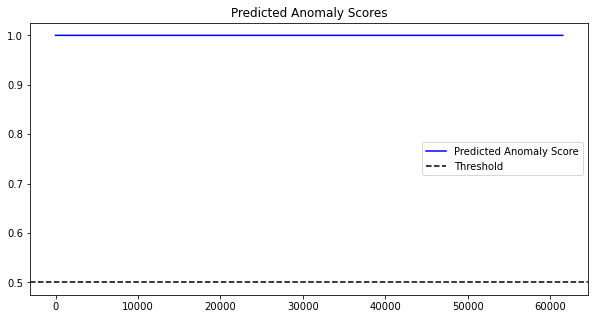

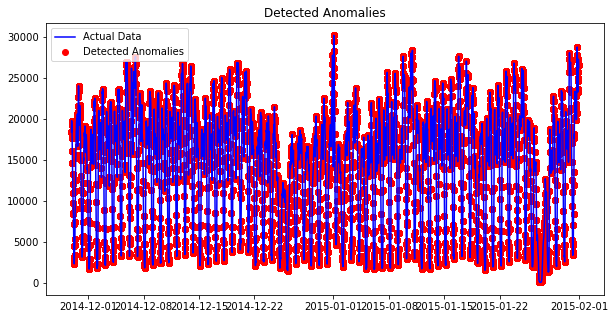

In [50]:
import matplotlib.pyplot as plt

# Plot predicted anomaly scores
plt.figure(figsize=(10,5))
plt.plot(y_pred.flatten(), label='Predicted Anomaly Score', color='blue')
plt.axhline(y=threshold, linestyle='--', color='black', label='Threshold')
plt.legend()
plt.title('Predicted Anomaly Scores')

# Detect anomalies
anomaly_indices = np.where(y_pred > threshold)[0]
anomaly_dates = df.index[train_size+sequence_length:][anomaly_indices]
anomaly_values = df['value'].iloc[train_size+sequence_length:][anomaly_indices]

# Plot detected anomalies
plt.figure(figsize=(10,5))
plt.plot(df.index[train_size+sequence_length:], df['value'].iloc[train_size+sequence_length:], label='Actual Data', color='blue')
plt.scatter(anomaly_dates, anomaly_values, color='red', label='Detected Anomalies')
plt.legend()
plt.title('Detected Anomalies')


In [45]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load data
url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realAdExchange/exchange-4_cpc_results.csv'
df = pd.read_csv(url, header=0, index_col=0, parse_dates=True)

# Prepare data
X = df.values
n_clusters = range(2, 11) # number of clusters to try

# Find optimal number of clusters using silhouette score
silhouette_scores = []
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42).fit(X)
    labels = kmeans.predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)
    
optimal_n_clusters = n_clusters[np.argmax(silhouette_scores)]
print("Optimal number of clusters:", optimal_n_clusters)

# Train K-Means model on optimal number of clusters
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42).fit(X)

# Detect anomalies by finding data points with distance greater than a certain threshold from the nearest cluster center
distances = kmeans.transform(X)
threshold = np.percentile(distances, 95)
anomaly_indices = np.where(distances > threshold)
print("Number of anomalies detected:", len(anomaly_indices[0]))


Optimal number of clusters: 2
Number of anomalies detected: 165


# Machine Learning-based Methods
Clustering

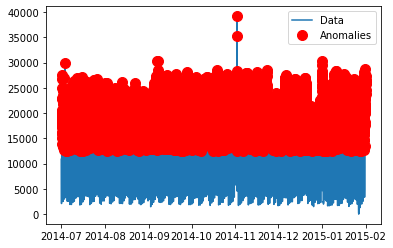

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load data
url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv'
df = pd.read_csv(url, header=0, index_col=0, parse_dates=True)

# Fit K-means clustering model
kmeans = KMeans(n_clusters=2, random_state=0).fit(df[['value']])

# Identify anomalous data points
anomalies_cluster = df[kmeans.predict(df[['value']]) == 1]

# Plot results
plt.plot(df.index, df['value'], label='Data')
plt.plot(anomalies_cluster.index, anomalies_cluster['value'], 'ro', markersize=10, label='Anomalies')
plt.legend(loc='best')
plt.show()


# Classification

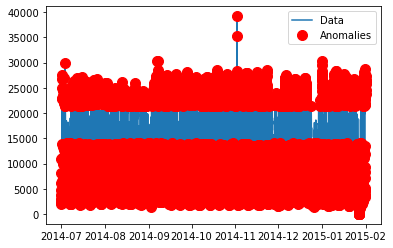

In [11]:
from sklearn.ensemble import IsolationForest

# Load data
url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv'
df = pd.read_csv(url, header=0, index_col=0, parse_dates=True)

# Fit Isolation Forest model
clf = IsolationForest(random_state=0).fit(df[['value']])

# Identify anomalous data points
anomalies_classify = df[clf.predict(df[['value']]) == -1]

# Plot results
plt.plot(df.index, df['value'], label='Data')
plt.plot(anomalies_classify.index, anomalies_classify['value'], 'ro', markersize=10, label='Anomalies')
plt.legend(loc='best')
plt.show()


# Mahalanobis Distance Mahalanobis Distance

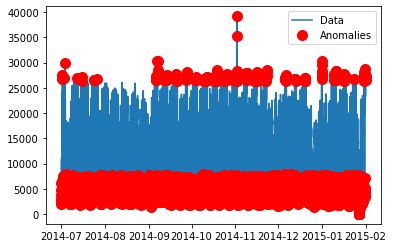

In [32]:
from sklearn.covariance import MinCovDet

# Load data
url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv'
df = pd.read_csv(url, header=0, index_col=0, parse_dates=True)

# Calculate Mahalanobis distance for each data point
mcd = MinCovDet().fit(df[['value']])
mahalanobis = mcd.mahalanobis(df[['value']])

# Set threshold for anomaly detection
threshold = 3

# Identify anomalous data points
anomalies_mahalanobis = df[mahalanobis > threshold]

# Plot results
plt.plot(df.index, df['value'], label='Data')
plt.plot(anomalies_mahalanobis.index, anomalies_mahalanobis['value'], 'ro', markersize=10, label='Anomalies')
plt.legend(loc='best')
plt.show()


# Z-score Statistical Methods

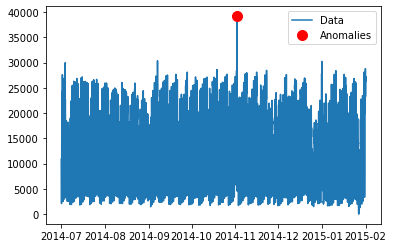

In [33]:
from scipy.stats import zscore

# Load data
url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv'
df = pd.read_csv(url, header=0, index_col=0, parse_dates=True)

# Calculate z-score for each data point
z_scores = zscore(df['value'])

# Set threshold for anomaly detection
threshold = 3

# Identify anomalous data points
anomalies_zscore = df[np.abs(z_scores) > threshold]

# Plot results
plt.plot(df.index, df['value'], label='Data')
plt.plot(anomalies_zscore.index, anomalies_zscore['value'], 'ro', markersize=10, label='Anomalies')
plt.legend(loc='best')
plt.show()


# Time-Series Anomaly Detection using ARIMA:

In [37]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Load data
url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv'
df = pd.read_csv(url, header=0, index_col=0, parse_dates=True)

# Prepare data
train_size = int(len(df) * 0.7) # use 70% of data for training
train_data = df.iloc[:train_size]['value'].values
test_data = df.iloc[train_size:]['value'].values

# Train ARIMA model
model = ARIMA(train_data, order=(2, 0, 2))
model_fit = model.fit()

# Detect anomalies by finding data points with residual greater than a certain threshold
residuals = model_fit.resid
threshold = np.percentile(np.abs(residuals), 99)
anomaly_indices = np.where(np.abs(residuals) > threshold)
print("Number of anomalies detected:", len(anomaly_indices[0]))


Number of anomalies detected: 73


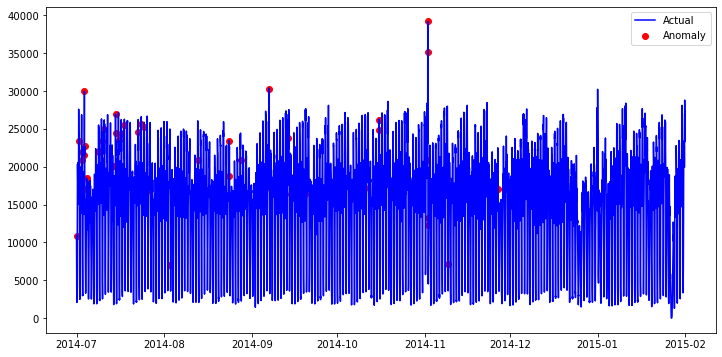

In [38]:
import matplotlib.pyplot as plt

# Plot data and anomalies
plt.figure(figsize=(12,6))
plt.plot(df.index, df['value'], color='blue', label='Actual')
plt.scatter(df.iloc[anomaly_indices].index, df.iloc[anomaly_indices]['value'], color='red', label='Anomaly')
plt.legend()
plt.show()


# Clustering-Based Anomaly Detection using K-Means:

In [35]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load data
url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realAdExchange/exchange-4_cpc_results.csv'
df = pd.read_csv(url, header=0, index_col=0, parse_dates=True)

# Prepare data
X = df.values
n_clusters = range(2, 11) # number of clusters to try

# Find optimal number of clusters using silhouette score
silhouette_scores = []
for n in n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42).fit(X)
    labels = kmeans.predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)
    
optimal_n_clusters = n_clusters[np.argmax(silhouette_scores)]
print("Optimal number of clusters:", optimal_n_clusters)

# Train K-Means model on optimal number of clusters
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42).fit(X)

# Detect anomalies by finding data points with distance greater than a certain threshold from the nearest cluster center
distances = kmeans.transform(X)
threshold = np.percentile(distances, 95)
anomaly_indices = np.where(distances > threshold)
print("Number of anomalies detected:", len(anomaly_indices[0]))


Optimal number of clusters: 2
Number of anomalies detected: 165


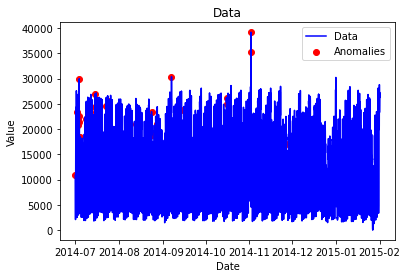

In [39]:
import matplotlib.pyplot as plt

# Plot data
plt.plot(df.index, df['value'], color='blue')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Data')

# Plot anomalies
anomaly_dates = df.iloc[anomaly_indices[0]].index
anomaly_values = df.iloc[anomaly_indices[0]]['value']
plt.scatter(anomaly_dates, anomaly_values, color='red')
plt.legend(['Data', 'Anomalies'])

plt.show()
